# A Catalog of Micro Frontends Anti-patterns

This Jupyter Notebook contains the harmfulness analysis applied to the paper _A Catalog of Micro Frontends Anti-patterns_, which includes:

1. A **boxplot** of harmfulness scores for each anti-pattern.
1. Performing the **Shapiro-Wilk Test** from `scipy` to test the normality of the samples.
1. Performing the **Friedman Test** from `scipy` to test if there is a significant difference between the samples.
1. Conducting the **Dunn Test** from `scikit-posthocs` to test for significant differences between samples in a pairwise manner.

# Setup

Installs the `scikit-posthocs`, which we will use to apply the Dunn Test.

In [ ]:
!pip install scikit-posthocs

Imports all necessary libs to run the notebook.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, shapiro

## Harmfullness Boxplot

The `harmfulness_scores` contains the data from the survey results, which we will analyze in this notebook.

In [ ]:
harmfulness_scores = {
    'Cyclic Dependency': [8, 8, 8, 10, 9, 10, 9, 8, 8, 7, 9, 6, 8, 8, 9, 6, 7, 7, 8, 6],
    'Knot Micro Frontend': [8, 7, 7, 8, 6, 6, 7, 7, 10, 9, 8, 7, 8, 7, 9, 7, 8, 8, 10, 4],
    'Hub-like Dependency': [7, 7, 8, 4, 2, 3, 7, 9, 10, 10, 7, 8, 10, 10, 10, 8, 8, 6, 7, 6],
    'Nano Frontend': [6, 9, 6, 6, 5, 7, 5, 3, 8, 6, 10, 10, 6, 7, 8, 8, 7, 3, 10, 2],
    'Mega Frontend': [7, 6, 7, 7, 5, 9, 9, 5, 7, 6, 6, 6, 7, 9, 10, 8, 7, 9, 10, 9],
    'Micro Frontends Greedy': [7, 10, 6, 6, 7, 6, 8, 1, 8, 9, 6, 7, 6, 8, 9, 7, 8, 6, 8, 1],
    'No CI/CD': [10, 10, 9, 10, 10, 10, 9, 10, 10, 10, 10, 8, 9, 7, 10, 10, 9, 10, 10, 7],
    'No Versioning': [10, 8, 7, 10, 3, 10, 6, 8, 10, 9, 10, 7, 9, 9, 10, 2, 9, 10, 10, 10],
    'Lack of Skeleton': [8, 7, 8, 8, 8, 8, 7, 9, 8, 5, 10, 9, 5, 6, 10, 8, 6, 5, 10, 5],
    'Common Ownership': [10, 8, 8, 8, 6, 10, 6, 6, 7, 7, 7, 9, 7, 8, 9, 9, 6, 10, 10, 10],
    'Golden Hammer': [5, 8, 7, 7, 6, 7, 4, 5, 6, 7, 3, 5, 8, 7, 6, 4, 6, 6, 10, 4],
    'Micro Frontend as the Goal': [10, 10, 6, 9, 9, 8, 5, 7, 8, 8, 8, 9, 7, 8, 8, 6, 8, 3, 8, 8]
}
df_harmfulness_scores = pd.DataFrame(harmfulness_scores)
df_melted_harmfulness_scores = df_harmfulness_scores.melt(var_name='Anti-Pattern', value_name='Harmfulness')

Plots the boxplot to visualize the distribution of the samples.

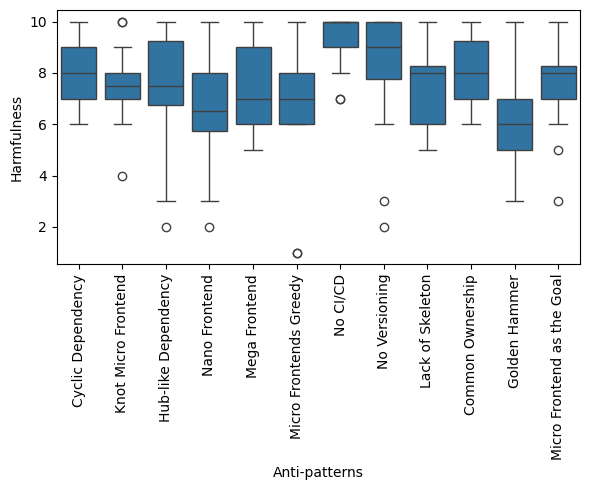

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(x='Anti-Pattern', y='Harmfulness', data=df_melted_harmfulness_scores)
plt.xticks(rotation=90)
plt.xlabel('Anti-patterns')
plt.ylabel('Harmfulness')
plt.tight_layout()
plt.show()

### Shapiro-Wilk Test

Tests the normality of the samples.

In [ ]:
shapiro_results = {}

for group in df_harmfulness_scores.columns:
    stat, p_value = shapiro(df_harmfulness_scores[group])
    shapiro_results[group] = {'statistic': stat, 'p-value': p_value}

shapiro_results_df = pd.DataFrame(shapiro_results).T
shapiro_results_df.columns = ['Statistic', 'P-value']
shapiro_results_df['Normal'] = shapiro_results_df['P-value'] >= 0.05
shapiro_results_df

,Statistic,P-value,Normal
Cyclic Dependency,0.915984,0.082952,True
Knot Micro Frontend,0.923690,0.116706,True
Hub-like Dependency,0.894414,0.032444,False
Nano Frontend,0.946113,0.311911,True
Mega Frontend,0.913331,0.073787,True
Micro Frontends Greedy,0.818960,0.001680,False
No CI/CD,0.654823,0.000012,False
No Versioning,0.736721,0.000113,False
Lack of Skeleton,0.899307,0.040024,False
Common Ownership,0.882021,0.019241,False


Since not all samples follow a normal distribution ($p$-value < 0.05), we should apply non-parametric tests that do not assume normality.

### Friedman Test

Tests if there is a significant difference between the samples.

In [ ]:
stat, p_value = friedmanchisquare(*[df_harmfulness_scores[col] for col in df_harmfulness_scores.columns])
print(f'Friedman Test: Statistic={stat}, p-value={p_value}')
friedman_results = pd.DataFrame({
    'Test Statistic': [stat],
    'p-value': [p_value]
}, index=['Friedman Test'])

if p_value < 0.05:
    print("O teste de Friedman é significativo. Pode aplicar o teste de Dunn.")
else:
    print("O teste de Friedman não é significativo. Não é necessário aplicar o teste de Dunn.")

Friedman Test: Statistic=53.30279850746276, p-value=1.5814231295756244e-07
O teste de Friedman é significativo. Pode aplicar o teste de Dunn.


Since $p$-value is lower than $0.05$, there are statistically significant differences between the samples, and therefore, the Dunn's test can be applied to identify which specific samples are different.

### Dunn Test

Tests for significant differences between samples in a pairwise manner.

In [ ]:
print('Resultados do teste de Dunn:')
dunn_results = sp.posthoc_dunn(df_melted_harmfulness_scores, group_col='Anti-Pattern', val_col='Harmfulness', p_adjust='holm')
dunn_df = pd.DataFrame(dunn_results)
dunn_df

Resultados do teste de Dunn:


,Common Ownership,Cyclic Dependency,Golden Hammer,Hub-like Dependency,Knot Micro Frontend,Lack of Skeleton,Mega Frontend,Micro Frontend as the Goal,Micro Frontends Greedy,Nano Frontend,No CI/CD,No Versioning
Common Ownership,1.000000,1.000000,6.101968e-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.197288e-01,1.000000
Cyclic Dependency,1.000000,1.000000,9.849469e-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.749513e-01,1.000000
Golden Hammer,0.061020,0.098495,1.000000e+00,0.612484,0.776646,0.795251,1.000000,0.274951,1.000000,1.000000,2.141583e-07,0.000799
Hub-like Dependency,1.000000,1.000000,6.124838e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.779223e-02,1.000000
Knot Micro Frontend,1.000000,1.000000,7.766463e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.725743e-02,1.000000
Lack of Skeleton,1.000000,1.000000,7.952511e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.607296e-02,1.000000
Mega Frontend,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.055079e-02,1.000000
Micro Frontend as the Goal,1.000000,1.000000,2.749513e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.849469e-02,1.000000
Micro Frontends Greedy,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.968902e-04,0.162764
Nano Frontend,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.554565e-04,0.088688


If the p-value of the Dunn's test is less than 0.05, the difference between the compared groups is statistically significant with 95% confidence. The figure below shows the anti-pattern pairs with significant differences highlighted.

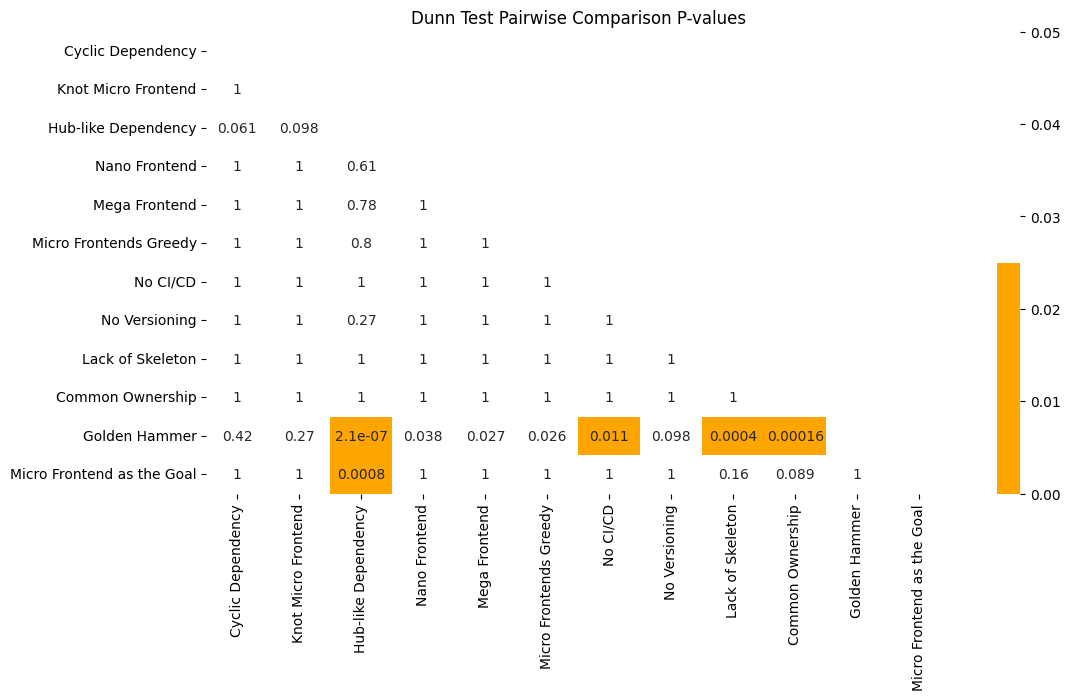

In [ ]:
plt.figure(figsize=(12, 6))
mask = np.triu(np.ones_like(dunn_results, dtype=bool))
sns.heatmap(
    dunn_df,
    annot=True,
    mask=mask,
    cmap=sns.color_palette(['orange', 'white']),
    vmin=0,
    vmax=0.05,
    cbar=True,
    xticklabels=harmfulness_scores.keys(),
    yticklabels=harmfulness_scores.keys(),
)
plt.title('Dunn Test Pairwise Comparison P-values')
plt.show()